# Building the Classifier

In [28]:
import pickle
import pandas as pd
import numpy as np
from os.path import join

from sklearn import svm
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Load all available training features into one big dataframe

In [5]:
regions = regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3', 'dennery']

In [6]:
columns = ['id', 'features', 'label']
df_train_global = pd.DataFrame(columns=columns)

pickle_path = join('..', '..', 'pickles')
for region in regions:
    try:
        with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl'), 'rb') as f:
            df_train = pickle.load(f)
            df_train_global = pd.concat([df_train_global, df_train], ignore_index=True)
    except:
        print("Error reading training data for region ", region)
    

In [7]:
df_train_global.head()
df_train_global = df_train_global.sort_values(by=['id'])

### Expand the dataframe such that instead of a list of features, every feature has its one column

In [8]:
feature_matrix_global = df_train_global['features'].to_numpy()
feature_matrix_global = np.column_stack(feature_matrix_global).transpose()

labels_global = df_train_global['label'].to_numpy().astype('int')

In [9]:
scaler = StandardScaler()
scaler.fit(feature_matrix_global)
feature_matrix_scaled = scaler.transform(feature_matrix_global)

In [10]:
print(feature_matrix_global.shape)
print(labels_global.shape)

(14852, 2048)
(14852,)


## 3. Train an SVM Classifier

In [ ]:
clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr', verbose=1)
clf.fit(feature_matrix_global, labels_global)

In [ ]:
#with open(join(pickle_path, 'classifier_resnet50_avg_retrained_all_scaled.pkl' ), 'wb') as f:
#    pickle.dump(clf, f)

## 4. Train a Random Forest Model

In [11]:
forest = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=0, n_jobs=8)
forest.fit(feature_matrix_global, labels_global) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1][:200]
feature_matrix_selected = feature_matrix_global[:, indices]

In [23]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_matrix_global,
                                                                            labels_global,
                                                                            test_size=0.33,
                                                                            random_state=42)

clf = svm.SVC(gamma='scale', probability=True, C=100, decision_function_shape='ovr')
clf.fit(features_train, labels_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [24]:
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

In [25]:
predicted_labels = clf.predict(features_test)
cm = confusion_matrix(labels_test, predicted_labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm / row_sums

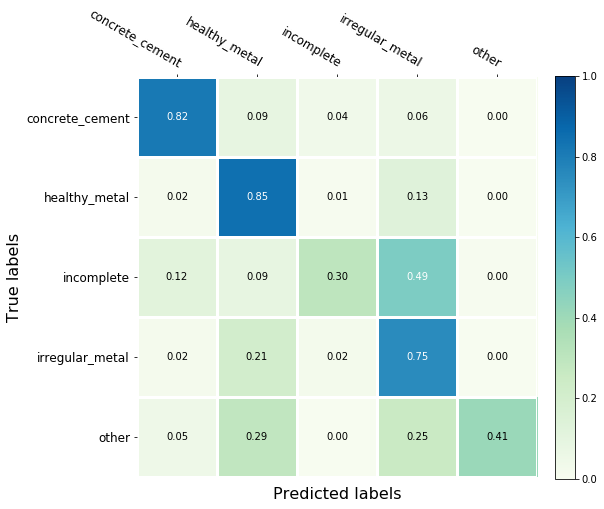

In [26]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(figsize=(8.5, 8.5))
im, cbar = utils.heatmap(cm_norm,  materials.keys(), materials.keys(), ax=ax,
                   cmap="GnBu")
texts = utils.annotate_heatmap(im)

fig.tight_layout()
plt.show()

fname = join('..', 'documentation', 'figures', 'results', 'nn_based_cm.png')
fig.savefig(fname)

Calculate log loss

In [27]:
pred_probas = clf.predict_proba(features_test)
log_loss = log_loss(labels_test, pred_probas)
log_loss

NameError: name 'sklearn' is not defined

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
cv_results = cross_validate(clf, feature_matrix_selected, labels_global,
                            cv=5, scoring=('f1_macro', 'f1_micro', 'accuracy', 'balanced_accuracy'),
                            n_jobs=7)

In [ ]:
cv_results